<a href="https://www.kaggle.com/code/shreyanshmanavshukla/unsloth-finetuned-llm-ai-agent?scriptVersionId=256808213" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Libraries

In [1]:
%%time
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth

CPU times: user 34.9 ms, sys: 26.7 ms, total: 61.5 ms
Wall time: 14.1 s


In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
hf_tokens = user_secrets.get_secret("HUGGINGFACE_TOKEN")  # secret hugging face token


In [3]:
%%time
%%capture
!pip install langgraph langchain-community


CPU times: user 23.4 ms, sys: 7.89 ms, total: 31.3 ms
Wall time: 7.78 s


# Base Model

In [4]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",

    "unsloth/Llama-3.3-70B-Instruct-bnb-4bit" # NEW! Llama 3.3 70B!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-08-19 11:54:35.405874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755604475.767475      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755604475.876842      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.8.7: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.35G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

In [5]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.8.7 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


# Data Preprcess

In [6]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("mlabonne/FineTome-100k", split = "train")

README.md:   0%|          | 0.00/982 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [7]:
from unsloth.chat_templates import standardize_sharegpt
dataset = standardize_sharegpt(dataset)
dataset = dataset.map(formatting_prompts_func, batched = True,)

Unsloth: Standardizing formats (num_proc=4):   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [8]:
dataset[5]["conversations"]

[{'content': 'How do astronomers determine the original wavelength of light emitted by a celestial body at rest, which is necessary for measuring its speed using the Doppler effect?',
  'role': 'user'},
 {'content': 'Astronomers make use of the unique spectral fingerprints of elements found in stars. These elements emit and absorb light at specific, known wavelengths, forming an absorption spectrum. By analyzing the light received from distant stars and comparing it to the laboratory-measured spectra of these elements, astronomers can identify the shifts in these wavelengths due to the Doppler effect. The observed shift tells them the extent to which the light has been redshifted or blueshifted, thereby allowing them to calculate the speed of the star along the line of sight relative to Earth.',
  'role': 'assistant'}]

In [9]:
dataset[5]["text"]

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nHow do astronomers determine the original wavelength of light emitted by a celestial body at rest, which is necessary for measuring its speed using the Doppler effect?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nAstronomers make use of the unique spectral fingerprints of elements found in stars. These elements emit and absorb light at specific, known wavelengths, forming an absorption spectrum. By analyzing the light received from distant stars and comparing it to the laboratory-measured spectra of these elements, astronomers can identify the shifts in these wavelengths due to the Doppler effect. The observed shift tells them the extent to which the light has been redshifted or blueshifted, thereby allowing them to calculate the speed of the star along the line of sight relative to Earth.<|

# Fine Tune

In [10]:
from trl import SFTConfig, SFTTrainer
from transformers import DataCollatorForSeq2Seq
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    packing = False, # Can make training 5x faster for short sequences.
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 60,
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/100000 [00:00<?, ? examples/s]

In [11]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

Map (num_proc=4):   0%|          | 0/100000 [00:00<?, ? examples/s]

In [12]:
tokenizer.decode(trainer.train_dataset[5]["input_ids"])

'<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nHow do astronomers determine the original wavelength of light emitted by a celestial body at rest, which is necessary for measuring its speed using the Doppler effect?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nAstronomers make use of the unique spectral fingerprints of elements found in stars. These elements emit and absorb light at specific, known wavelengths, forming an absorption spectrum. By analyzing the light received from distant stars and comparing it to the laboratory-measured spectra of these elements, astronomers can identify the shifts in these wavelengths due to the Doppler effect. The observed shift tells them the extent to which the light has been redshifted or blueshifted, thereby allowing them to calculate the speed of the star along the line of sight rel

In [13]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[5]["labels"]])

'                                                                  Astronomers make use of the unique spectral fingerprints of elements found in stars. These elements emit and absorb light at specific, known wavelengths, forming an absorption spectrum. By analyzing the light received from distant stars and comparing it to the laboratory-measured spectra of these elements, astronomers can identify the shifts in these wavelengths due to the Doppler effect. The observed shift tells them the extent to which the light has been redshifted or blueshifted, thereby allowing them to calculate the speed of the star along the line of sight relative to Earth.<|eot_id|>'

In [14]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True,
                         temperature = 1.5, min_p = 0.1)
tokenizer.batch_decode(outputs)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


['<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nContinue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nThe next numbers in the Fibonacci sequence are:\n\n5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946,']

# Saving

In [15]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/chat_template.jinja',
 'lora_model/tokenizer.json')

In [16]:
# Merge to 16bit
if False: model.save_pretrained_merged("model_16bit", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("ShuklaShreyansh/LoraModel_16bit", tokenizer, save_method = "merged_16bit", token = hf_tokens)

# Merge to 4bit
if False: model.save_pretrained_merged("model_4bit", tokenizer, save_method = "merged_4bit_forced",)
if False: model.push_to_hub_merged("ShuklaShreyansh/LoraModel_4bit", tokenizer, save_method = "merged_4bit", token = hf_tokens)

# Just LoRA adapters
if False:
    model.save_pretrained("model")
    tokenizer.save_pretrained("model")
if False:
    model.push_to_hub("ShuklaShreyansh/LoraModel", token = hf_tokens)
    tokenizer.push_to_hub("ShuklaShreyansh/LoraModel", token = hf_tokens)

# inference

In [17]:
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "/kaggle/working/lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Describe a tall tower in the capital of France."},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

==((====))==  Unsloth 2025.8.7: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
The tall tower I would like to describe is the Eiffel Tower, which is located in the capital city of France, Paris. The Eiffel Tower is an iconic iron lattice tower that stands 324 meters (1,063 feet) tall. It was built for the 1889 World's Fair and has since become one of the most recognizable landmarks in the world.

The tower is a masterpiece of engineering and architecture, with its four main pillars supporting a central core that rises to the top. The lattice-like structure is made up of interlocking girders and beams, wh

# AI Agent

In [18]:
# From Hugging Face
if False:
    from unsloth import FastLanguageModel
    import torch
    
    model_name = 'ShuklaShreyansh/LoraModel_16bit'
    
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=model_name,  # your Hugging Face repo
        max_seq_length=2048,
        dtype=None,          # Auto-detect FP16/BF16
        load_in_4bit=False,   # saves memory, optional
        token = hf_tokens
    )
    
    FastLanguageModel.for_inference(model)
    



In [19]:
# Optional speed boost
model = torch.compile(model)

In [20]:
from transformers import pipeline
from langchain_community.llms import HuggingFacePipeline

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=256,
    temperature=0.7,
    top_p=0.9,
)

llm = HuggingFacePipeline(pipeline=pipe)


Device set to use cuda:0
The model 'OptimizedModule' is not supported for text-generation. Supported models are ['PeftModelForCausalLM', 'AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BitNetForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadMo

# Workflow

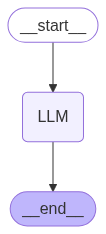

In [21]:
from langgraph.graph import StateGraph, END

# Define the state
class ChatState(dict):
    user_input: str
    model_output: str

# Create the graph
graph = StateGraph(ChatState)

# Node: Use your LLM
def llm_node(state: ChatState):
    response = llm(state["user_input"])
    return {"model_output": response}

# Add nodes
graph.add_node("LLM", llm_node)

# Define flow
graph.set_entry_point("LLM")
graph.add_edge("LLM", END)

# Compile graph
app = graph.compile()
app

In [22]:
state = {"user_input": "Explain crop rotation in simple words."}
result = app.invoke(state)

print(result["model_output"])


/tmp/ipykernel_19/3511224510.py:13: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm(state["user_input"])


Explain crop rotation in simple words. Crop rotation is a technique that helps improve soil health, reduce pests and diseases, and increase crop yields. Here's how it works:
Imagine you have a garden with a single crop, like corn. If you plant corn every year, it can deplete the soil of essential nutrients like nitrogen, phosphorus, and potassium. This can lead to poor soil health and reduced crop yields.
To address this, you can rotate crops to different parts of your garden. For example, you can plant corn in one area, followed by a crop like beans, and then in another area, plant beans followed by corn.
By rotating crops, you're allowing the soil to recover from the depletion of nutrients. The different crops will also bring in new nutrients, and some crops, like beans, can even help fix nitrogen in the soil.
Crop rotation can also help reduce pests and diseases by breaking the life cycle of pests and diseases. For example, some pests, like aphids, are more active in certain crops, 

# For more information
checkout   [Unsloth Github](https://github.com/unslothai/unsloth)